## LOGISTIC REGRESSION

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio

In [40]:
data = scio.loadmat('HW2_Data/data1')

In [41]:
X_trn = np.insert(data['X_trn'], 0, 1, axis=1)
y_trn = data['Y_trn']
X_tst = np.insert(data['X_tst'], 0, 1, axis=1)
y_tst = data['Y_tst']

In [42]:
X_train = np.matrix(X_trn)
y_train = np.matrix(y_trn)
X_test = np.matrix(X_tst)
y_test = np.matrix(y_tst)
theta = np.matrix(np.zeros(3))

In [43]:
def sigmoid(x):
    '''Sigmoid function of x.'''
    return 1/(1+np.exp(-x))

In [44]:
def computeCost(X, y, theta, l):
    y_hat = sigmoid(X*theta.T)
    m = len(X)
    reg = l * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    cost = (-1/m) * (y.T*np.log(y_hat) + (1-y).T*(np.log(1-y_hat))) + reg
    return cost

In [45]:
def plotPrediction(X, y, theta, title = 'train set'):
    X = np.concatenate((X, y), axis=1)
    X = np.array(X)
    X1 = X[np.ix_(X[:, 3] == 0, (1,2))]
    X2 = X[np.ix_(X[:, 3] == 1, (1,2))]
    minimum = np.floor(X2.min())
    maximum = np.ceil(X2.max())
    plt.scatter(X1[:, 0], X1[:, 1], marker='+', color="blue", label="Class 0")
    plt.scatter(X2[:, 0], X2[:, 1], marker='o', color="green", label="Class 1")
    x = np.linspace(-3, 3, 10)
    theta=np.array(theta)
    slope = -theta[:,1]/theta[:,2]
    intercept = -theta[:, 0]/theta[:,2]
    y_pred = slope*x + intercept
    plt.ylim(minimum, maximum)
    plt.plot(x, y_pred, color='red', label="Boundary")
    plt.title(title)
    plt.legend()
    plt.show()

In [46]:
def ridgeSGD(X, y, theta, alpha, minibatch_size, threshold, l):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    i = 1

    while True:
        for k in range(len(X) // minibatch_size):
            index_list = np.random.choice(len(X), size=minibatch_size, replace=False)
            X_batch = X[index_list]
            y_batch = y[index_list]
            error = sigmoid(X_batch * theta.T) - y_batch
            
            for j in range(parameters):
                term = np.multiply(error, X_batch[:,j]) + np.multiply(l, theta)
                temp[0,j] = theta[0,j] - ((alpha / len(X_batch)) * np.sum(term))

            theta = temp
            
        cost.append(computeCost(X, y, theta, l))
        if cost[-2] - cost[-1] < threshold and cost[-2] - cost[-1] > 0:
            break
            
        if i % 50 == 0:
            print("Loss iter",i,": ",cost[-1])
        i += 1
        
    return theta, cost

In [47]:
def kFoldCV(X, y, fold, alpha, theta, m, precision):
    lam = np.arange(0.01, 0.1, 0.01)
    cost_lam = {}
    for l in lam:
        cost = 0
        items = int(len(X)/fold)
        if len(X)%fold != 0:
            items += 1
        for i in range(0,fold-1):
            data = np.concatenate((X, y), axis=1)
            np.random.shuffle(data)
            data_hold = data[i*items:(i+1)*items]
            data_train = np.delete(data, data_hold, axis=0)
            cols = data_train.shape[1]
            X_train = np.matrix(data_train[:, 0:cols-1])
            y_train = np.matrix(data_train[:, cols-1:])
            theta, _ = ridgeSGD(X_train, y_train, theta, alpha, m, precision, l)
            X_hold = np.matrix(data_hold[:, 0:cols-1])
            y_hold = np.matrix(data_hold[:, cols-1:])
            cost = cost + computeCost(X_hold, y_hold, theta, l)
        avg_cost= cost/fold
        cost_lam[l] = avg_cost
        best_lam = min(cost_lam, key=lambda k: cost_lam[k])
    return best_lam

In [48]:
alpha = 0.01
minibatch_size = 10
threshold = 0.01
fold = 10
lam = kFoldCV(X_train, y_train, fold, alpha, theta, minibatch_size, threshold)
print(lam)

/Users/siddhantbenadikar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]
/Users/siddhantbenadikar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  del sys.path[0]


0.02


In [49]:
theta, cost = ridgeSGD(X_train, y_train, theta, alpha, minibatch_size, threshold, lam)

In [50]:
theta

matrix([[ 0.19601532,  1.1141104 , -0.31229041]])

In [51]:
cost[-1]

matrix([[ 0.33544065]])

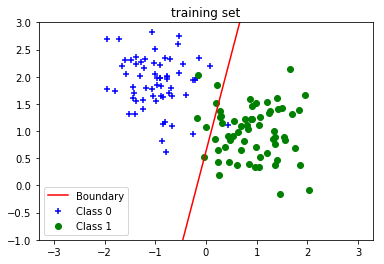

In [52]:
plotPrediction(X_train, y_train, theta,"training set")

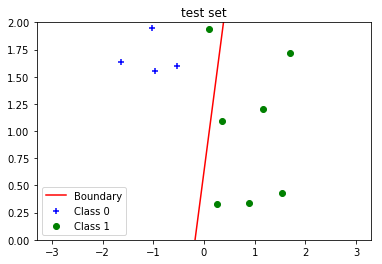

In [53]:
plotPrediction(X_test, y_test, theta, "test set")

In [54]:
computeCost(X_test, y_test, theta, lam)

matrix([[ 0.33946078]])

In [55]:
def classify(X, y, theta):
    res = sigmoid(X*theta.T)
    for i in range(len(res)):
        if res[i] < 0.5:
            res[i] = 0
        else:
            res[i] = 1
    return res

def classificationError(y, y_pred):
    count = 0
    for i in range(len(y)):
        if y_pred[i] != y[i]:
            count += 1
    return count

In [58]:
def classification_error_print(X_train, y_train, theta):
    y_pred = classify(X_train, y_train, theta)
    classification_error = classificationError(y_train, y_pred)
    classification_error_percent =  classification_error / len(y_pred) * 100
    print("Miss-classified points:", classification_error)
    print("The classification error percent is: {:0.2f}%".format(classification_error_percent))

In [59]:
classification_error_print(X_train, y_train, theta)

Miss-classified points: 7
The classification error percent is: 5.56%


In [60]:
classification_error_print(X_test, y_test, theta)

Miss-classified points: 1
The classification error percent is: 7.14%
